# Module 4 - Exercise 1: Resource Profiling

## Learning Objectives
- Understand GPU memory management and limitations
- Profile computation time differences between CPU and GPU
- Measure memory transfer overhead between devices
- Analyze training performance with different hyperparameters
- Learn to optimize resource usage in deep learning workflows

## Environment Setup

First, let's set up our environment and create helper functions for profiling.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Total GPU Memory: 15.83 GB


## Helper Functions

These functions will help us profile memory and time throughout the exercises.

In [3]:
def get_gpu_memory_info():
    """Get current GPU memory usage."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9  # GB
        reserved = torch.cuda.memory_reserved() / 1e9    # GB
        max_memory = torch.cuda.max_memory_allocated() / 1e9  # GB
        return {
            'allocated': allocated,
            'reserved': reserved,
            'max_allocated': max_memory
        }
    return None

def clear_gpu_memory():
    """Clear GPU memory cache."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        gc.collect()

def time_operation(func, *args, **kwargs):
    """Time a function execution."""
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    start = time.perf_counter()
    result = func(*args, **kwargs)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end = time.perf_counter()
    return result, end - start

def profile_memory_usage(func, *args, **kwargs):
    """Profile memory usage of a function."""
    clear_gpu_memory()
    initial_memory = get_gpu_memory_info()
    result = func(*args, **kwargs)
    final_memory = get_gpu_memory_info()

    if initial_memory and final_memory:
        memory_used = final_memory['allocated'] - (initial_memory['allocated'] if initial_memory else 0)
        return result, memory_used
    return result, 0

def visualize_results(results: Dict, title: str, ylabel: str):
    """Visualize profiling results."""
    plt.figure(figsize=(10, 6))
    keys = list(results.keys())
    values = list(results.values())

    bars = plt.bar(keys, values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## Section 1: Understanding Device Memory

In this section, we'll explore GPU memory limits and learn how to manage memory effectively.

### 1.1 Basic Memory Allocation

Let's start by understanding how tensors are allocated on different devices.

In [7]:
# TODO: Create a tensor of size (1000, 1000) on CPU
cpu_tensor = torch.randn((1000,1000), device= torch.device('cpu'))

# TODO: Move the tensor to GPU (if available) using .to(device)
gpu_tensor = cpu_tensor.to('cuda')

# Display memory info
if torch.cuda.is_available():
    print(f"CPU Tensor device: {cpu_tensor.device if cpu_tensor is not None else 'Not created'}")
    print(f"GPU Tensor device: {gpu_tensor.device if gpu_tensor is not None else 'Not created'}")
    memory_info = get_gpu_memory_info()
    if memory_info:
        print(f"GPU Memory Allocated: {memory_info['allocated']:.4f} GB")

CPU Tensor device: cpu
GPU Tensor device: cuda:0
GPU Memory Allocated: 0.0040 GB


### 1.2 Memory Limits Exploration

Now let's explore GPU memory limits by progressively allocating larger tensors.

In [12]:
def allocate_tensor_on_gpu(size_gb: float):
    """Try to allocate a tensor of given size in GB on GPU."""
    if not torch.cuda.is_available():
        print("GPU not available")
        return None

    # Calculate number of float32 elements needed
    num_elements = int(size_gb * 1e9 / 4)  # 4 bytes per float32

    try:
        tensor = torch.randn(num_elements, device='cuda')
        actual_size = tensor.element_size() * tensor.nelement() / 1e9
        print(f"✓ Successfully allocated {actual_size:.2f} GB tensor")
        return tensor
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"✗ Out of Memory! Could not allocate {size_gb:.2f} GB")
        else:
            print(f"✗ Error: {e}")
        return None

# TODO: Test different sizes to find your GPU's limit
# Start with small sizes and increase gradually
test_sizes = [0.1, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]  # in GB

allocated_tensors = []
for size in test_sizes:
    clear_gpu_memory()
    print(f"\nTrying to allocate {size} GB...")
    # TODO: Call allocate_tensor_on_gpu with the current size
    tensor = allocate_tensor_on_gpu(size)

    if tensor is not None:
        memory_info = get_gpu_memory_info()
        if memory_info:
            print(f"  Current GPU memory: {memory_info['allocated']:.2f}/{memory_info['reserved']:.2f} GB (allocated/reserved)")
        del tensor  # Free memory immediately


Trying to allocate 0.1 GB...
✓ Successfully allocated 0.10 GB tensor
  Current GPU memory: 0.10/0.12 GB (allocated/reserved)

Trying to allocate 0.5 GB...
✓ Successfully allocated 0.50 GB tensor
  Current GPU memory: 0.50/0.52 GB (allocated/reserved)

Trying to allocate 1.0 GB...
✓ Successfully allocated 1.00 GB tensor
  Current GPU memory: 1.00/1.02 GB (allocated/reserved)

Trying to allocate 2.0 GB...
✓ Successfully allocated 2.00 GB tensor
  Current GPU memory: 2.00/2.02 GB (allocated/reserved)

Trying to allocate 4.0 GB...
✓ Successfully allocated 4.00 GB tensor
  Current GPU memory: 4.00/4.02 GB (allocated/reserved)

Trying to allocate 8.0 GB...
✓ Successfully allocated 8.00 GB tensor
  Current GPU memory: 8.00/8.02 GB (allocated/reserved)

Trying to allocate 16.0 GB...
✗ Out of Memory! Could not allocate 16.00 GB


### 1.3 Pushing GPU to OOM (Out of Memory)

**WARNING**: This will intentionally cause an Out of Memory error to understand GPU limits!

In [14]:
# TODO: Intentionally cause an OOM error by allocating multiple large tensors
# This helps understand what happens when you exceed GPU memory

if torch.cuda.is_available():
    print("Attempting to cause OOM error...")
    print("(This is intentional for learning purposes)\n")

    tensors = []
    try:
        for i in range(100):
            # TODO: Create a large tensor (e.g., 100MB each) and append to list
            # Hint: torch.randn(25_000_000, device='cuda') is ~100MB
            large_tensor = torch.randn(250000000, device='cuda')

            if large_tensor is not None:
                tensors.append(large_tensor)
                if i % 10 == 0:
                    memory_info = get_gpu_memory_info()
                    print(f"Iteration {i}: Allocated {memory_info['allocated']:.2f} GB")
    except RuntimeError as e:
        print(f"\n🔥 OOM Error occurred as expected!")
        print(f"Error message: {str(e)[:200]}...")
        print(f"\nManaged to allocate {len(tensors)} tensors before OOM")

    # Clean up
    tensors.clear()
    clear_gpu_memory()
else:
    print("GPU not available - skipping OOM test")

Attempting to cause OOM error...
(This is intentional for learning purposes)

Iteration 0: Allocated 1.00 GB
Iteration 10: Allocated 11.01 GB

🔥 OOM Error occurred as expected!
Error message: CUDA out of memory. Tried to allocate 954.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 660.12 MiB is free. Process 4524 has 14.09 GiB memory in use. Of the allocated memory 13.98 GiB is al...

Managed to allocate 15 tensors before OOM


## Section 2: Computation Profiling (CPU vs GPU)

Let's compare computation times between CPU and GPU for different operations.

### 2.1 Matrix Multiplication Profiling

In [18]:
def profile_matmul(size: int, device: str):
    """Profile matrix multiplication on given device."""
    A = torch.randn(size, size, device=device)
    B = torch.randn(size, size, device=device)

    # Warm-up
    _ = torch.matmul(A, B)

    # Actual timing
    _, elapsed = time_operation(torch.matmul, A, B)
    return elapsed

# TODO: Test different matrix sizes on CPU and GPU
matrix_sizes = [100, 500, 1000, 2000, 4000]
cpu_times = []
gpu_times = []

for size in matrix_sizes:
    print(f"\nTesting matrix size: {size}x{size}")

    # TODO: Profile on CPU
    cpu_time = profile_matmul(size,'cpu')  # Call profile_matmul with 'cpu'

    # TODO: Profile on GPU (if available)
    gpu_time = profile_matmul(size,'cuda')  # Call profile_matmul with 'cuda' if available

    if cpu_time is not None:
        cpu_times.append(cpu_time)
        print(f"  CPU Time: {cpu_time:.4f}s")

    if gpu_time is not None:
        gpu_times.append(gpu_time)
        print(f"  GPU Time: {gpu_time:.4f}s")
        if cpu_time:
            speedup = cpu_time / gpu_time
            print(f"  Speedup: {speedup:.2f}x")


Testing matrix size: 100x100
  CPU Time: 0.0001s
  GPU Time: 0.0001s
  Speedup: 0.83x

Testing matrix size: 500x500
  CPU Time: 0.0021s
  GPU Time: 0.0002s
  Speedup: 13.22x

Testing matrix size: 1000x1000
  CPU Time: 0.0143s
  GPU Time: 0.0009s
  Speedup: 16.28x

Testing matrix size: 2000x2000
  CPU Time: 0.1986s
  GPU Time: 0.0059s
  Speedup: 33.69x

Testing matrix size: 4000x4000
  CPU Time: 0.9179s
  GPU Time: 0.0456s
  Speedup: 20.14x


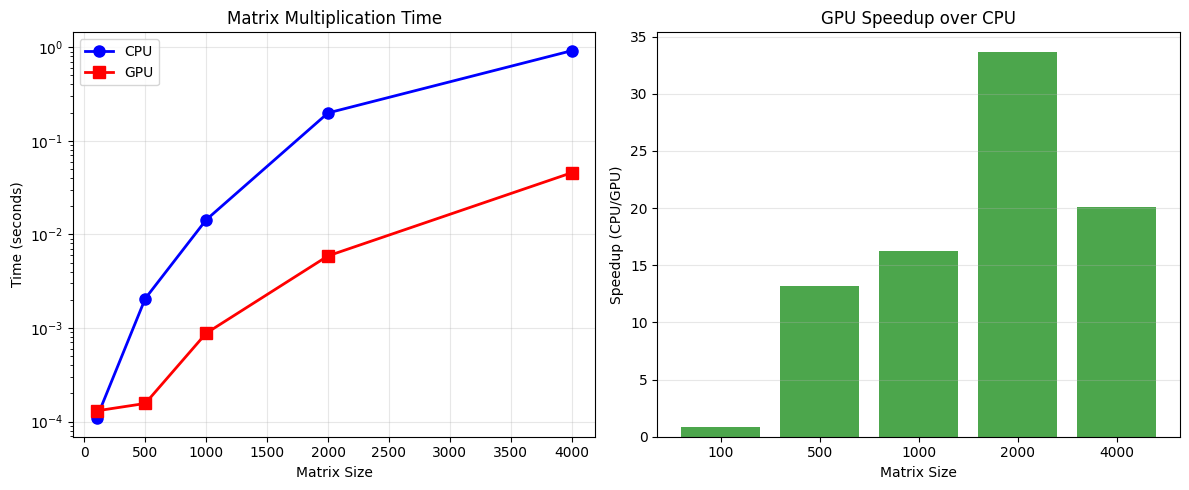

In [19]:
# Visualize the results
if cpu_times and gpu_times:
    plt.figure(figsize=(12, 5))

    # Plot times
    plt.subplot(1, 2, 1)
    plt.plot(matrix_sizes[:len(cpu_times)], cpu_times, 'b-o', label='CPU', linewidth=2, markersize=8)
    plt.plot(matrix_sizes[:len(gpu_times)], gpu_times, 'r-s', label='GPU', linewidth=2, markersize=8)
    plt.xlabel('Matrix Size')
    plt.ylabel('Time (seconds)')
    plt.title('Matrix Multiplication Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    # Plot speedup
    plt.subplot(1, 2, 2)
    speedups = [c/g for c, g in zip(cpu_times, gpu_times)]
    plt.bar(range(len(speedups)), speedups, color='green', alpha=0.7)
    plt.xlabel('Matrix Size')
    plt.ylabel('Speedup (CPU/GPU)')
    plt.title('GPU Speedup over CPU')
    plt.xticks(range(len(speedups)), matrix_sizes[:len(speedups)])
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

### 2.2 Different Operations Comparison

In [20]:
def benchmark_operations(size: int = 2000):
    """Benchmark different operations on CPU and GPU."""
    results = {'CPU': {}, 'GPU': {}}

    for device_name in ['CPU', 'GPU']:
        if device_name == 'GPU' and not torch.cuda.is_available():
            continue

        device = 'cuda' if device_name == 'GPU' else 'cpu'

        # Create test tensors
        A = torch.randn(size, size, device=device)
        B = torch.randn(size, size, device=device)

        # TODO: Benchmark matrix multiplication
        _, matmul_time = time_operation(torch.matmul, A, B)
        results[device_name]['MatMul'] = matmul_time

        # TODO: Benchmark element-wise operations
        _, add_time = time_operation(torch.add, A, B)
        results[device_name]['Addition'] = add_time

        # TODO: Benchmark activation functions
        _, relu_time = time_operation(torch.relu, A)
        results[device_name]['ReLU'] = relu_time

        # TODO: Benchmark reduction operations
        _, sum_time = time_operation(torch.sum, A)
        results[device_name]['Sum'] = sum_time

        # TODO: Benchmark convolution (smaller size for memory)
        conv_input = torch.randn(32, 3, 224, 224, device=device)
        conv = nn.Conv2d(3, 64, 3, padding=1).to(device)
        _, conv_time = time_operation(conv, conv_input)
        results[device_name]['Conv2D'] = conv_time

    return results

# Run benchmarks
print("Running operation benchmarks...")
benchmark_results = benchmark_operations()

# Display results
print("\nBenchmark Results:")
print("-" * 50)
for device_name, operations in benchmark_results.items():
    if operations:
        print(f"\n{device_name}:")
        for op_name, time_taken in operations.items():
            print(f"  {op_name:15s}: {time_taken:.6f}s")

Running operation benchmarks...

Benchmark Results:
--------------------------------------------------

CPU:
  MatMul         : 0.124421s
  Addition       : 0.015209s
  ReLU           : 0.013041s
  Sum            : 0.004421s
  Conv2D         : 0.578258s

GPU:
  MatMul         : 0.005957s
  Addition       : 0.029776s
  ReLU           : 0.033792s
  Sum            : 0.038411s
  Conv2D         : 0.500673s


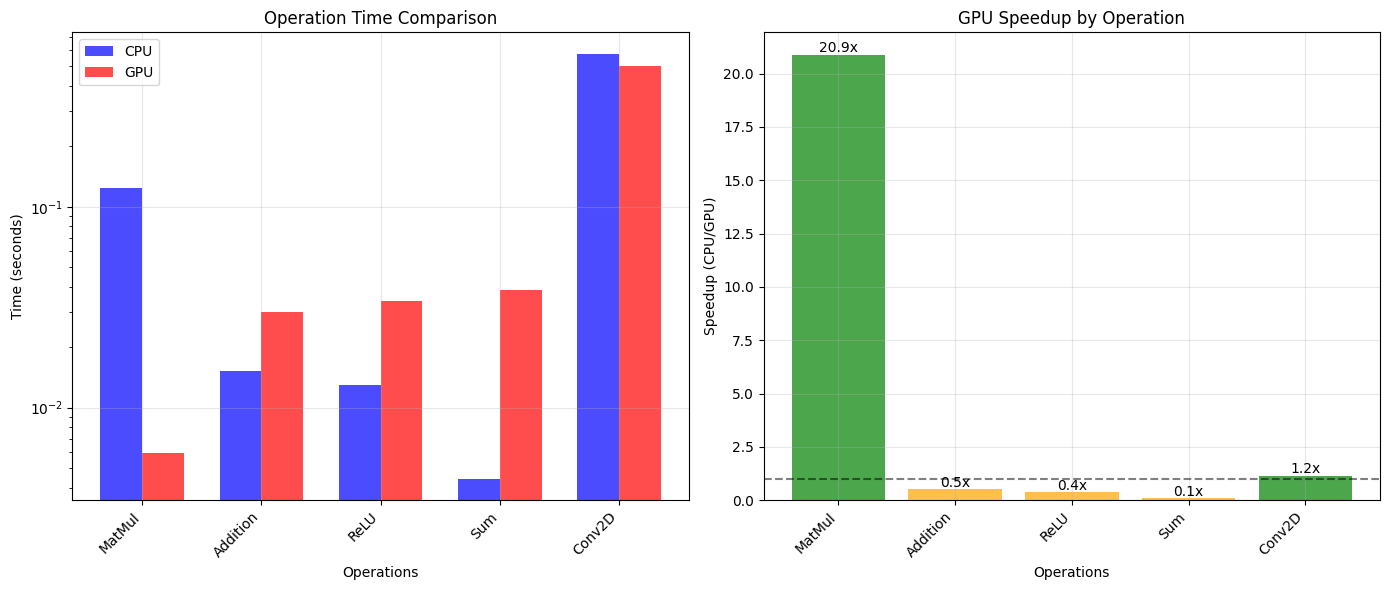

In [21]:
# Visualize operation comparison
if 'GPU' in benchmark_results and benchmark_results['GPU']:
    operations = list(benchmark_results['CPU'].keys())
    cpu_times = list(benchmark_results['CPU'].values())
    gpu_times = list(benchmark_results['GPU'].values())

    x = np.arange(len(operations))
    width = 0.35

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Time comparison
    ax1.bar(x - width/2, cpu_times, width, label='CPU', color='blue', alpha=0.7)
    ax1.bar(x + width/2, gpu_times, width, label='GPU', color='red', alpha=0.7)
    ax1.set_xlabel('Operations')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title('Operation Time Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(operations, rotation=45, ha='right')
    ax1.legend()
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)

    # Speedup
    speedups = [c/g for c, g in zip(cpu_times, gpu_times)]
    colors = ['green' if s > 1 else 'orange' for s in speedups]
    ax2.bar(operations, speedups, color=colors, alpha=0.7)
    ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Operations')
    ax2.set_ylabel('Speedup (CPU/GPU)')
    ax2.set_title('GPU Speedup by Operation')
    ax2.set_xticklabels(operations, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)

    # Add value labels
    for i, v in enumerate(speedups):
        ax2.text(i, v + 0.1, f'{v:.1f}x', ha='center')

    plt.tight_layout()
    plt.show()

## Section 3: Memory Transfer Overhead

Understanding the cost of moving data between CPU and GPU is crucial for optimization.

In [23]:
def measure_transfer_overhead(size_mb: float):
    """Measure the overhead of transferring data between CPU and GPU."""
    if not torch.cuda.is_available():
        return None

    # Create tensor on CPU
    num_elements = int(size_mb * 1e6 / 4)  # 4 bytes per float32
    cpu_tensor = torch.randn(num_elements)

    # Measure CPU to GPU transfer
    torch.cuda.synchronize()
    start = time.perf_counter()
    gpu_tensor = cpu_tensor.to('cuda')
    torch.cuda.synchronize()
    cpu_to_gpu_time = time.perf_counter() - start

    # Measure GPU to CPU transfer
    torch.cuda.synchronize()
    start = time.perf_counter()
    cpu_tensor_back = gpu_tensor.to('cpu')
    torch.cuda.synchronize()
    gpu_to_cpu_time = time.perf_counter() - start

    # Calculate bandwidth
    bandwidth_to_gpu = size_mb / cpu_to_gpu_time  # MB/s
    bandwidth_to_cpu = size_mb / gpu_to_cpu_time  # MB/s

    return {
        'size_mb': size_mb,
        'cpu_to_gpu_time': cpu_to_gpu_time,
        'gpu_to_cpu_time': gpu_to_cpu_time,
        'bandwidth_to_gpu': bandwidth_to_gpu,
        'bandwidth_to_cpu': bandwidth_to_cpu
    }

# TODO: Test different data sizes
transfer_sizes = [1, 10, 50, 100, 500, 1000]  # MB
transfer_results = []

print("Memory Transfer Overhead Analysis")
print("=" * 60)

for size in transfer_sizes:
    # TODO: Measure transfer overhead for current size
    result = measure_transfer_overhead(size)  # Call measure_transfer_overhead

    if result:
        transfer_results.append(result)
        print(f"\nSize: {size} MB")
        print(f"  CPU→GPU: {result['cpu_to_gpu_time']*1000:.2f} ms ({result['bandwidth_to_gpu']:.0f} MB/s)")
        print(f"  GPU→CPU: {result['gpu_to_cpu_time']*1000:.2f} ms ({result['bandwidth_to_cpu']:.0f} MB/s)")

Memory Transfer Overhead Analysis

Size: 1 MB
  CPU→GPU: 0.54 ms (1841 MB/s)
  GPU→CPU: 0.63 ms (1580 MB/s)

Size: 10 MB
  CPU→GPU: 2.06 ms (4847 MB/s)
  GPU→CPU: 6.73 ms (1487 MB/s)

Size: 50 MB
  CPU→GPU: 10.67 ms (4687 MB/s)
  GPU→CPU: 31.98 ms (1564 MB/s)

Size: 100 MB
  CPU→GPU: 21.10 ms (4739 MB/s)
  GPU→CPU: 64.10 ms (1560 MB/s)

Size: 500 MB
  CPU→GPU: 106.14 ms (4711 MB/s)
  GPU→CPU: 321.04 ms (1557 MB/s)

Size: 1000 MB
  CPU→GPU: 213.51 ms (4684 MB/s)
  GPU→CPU: 648.32 ms (1542 MB/s)


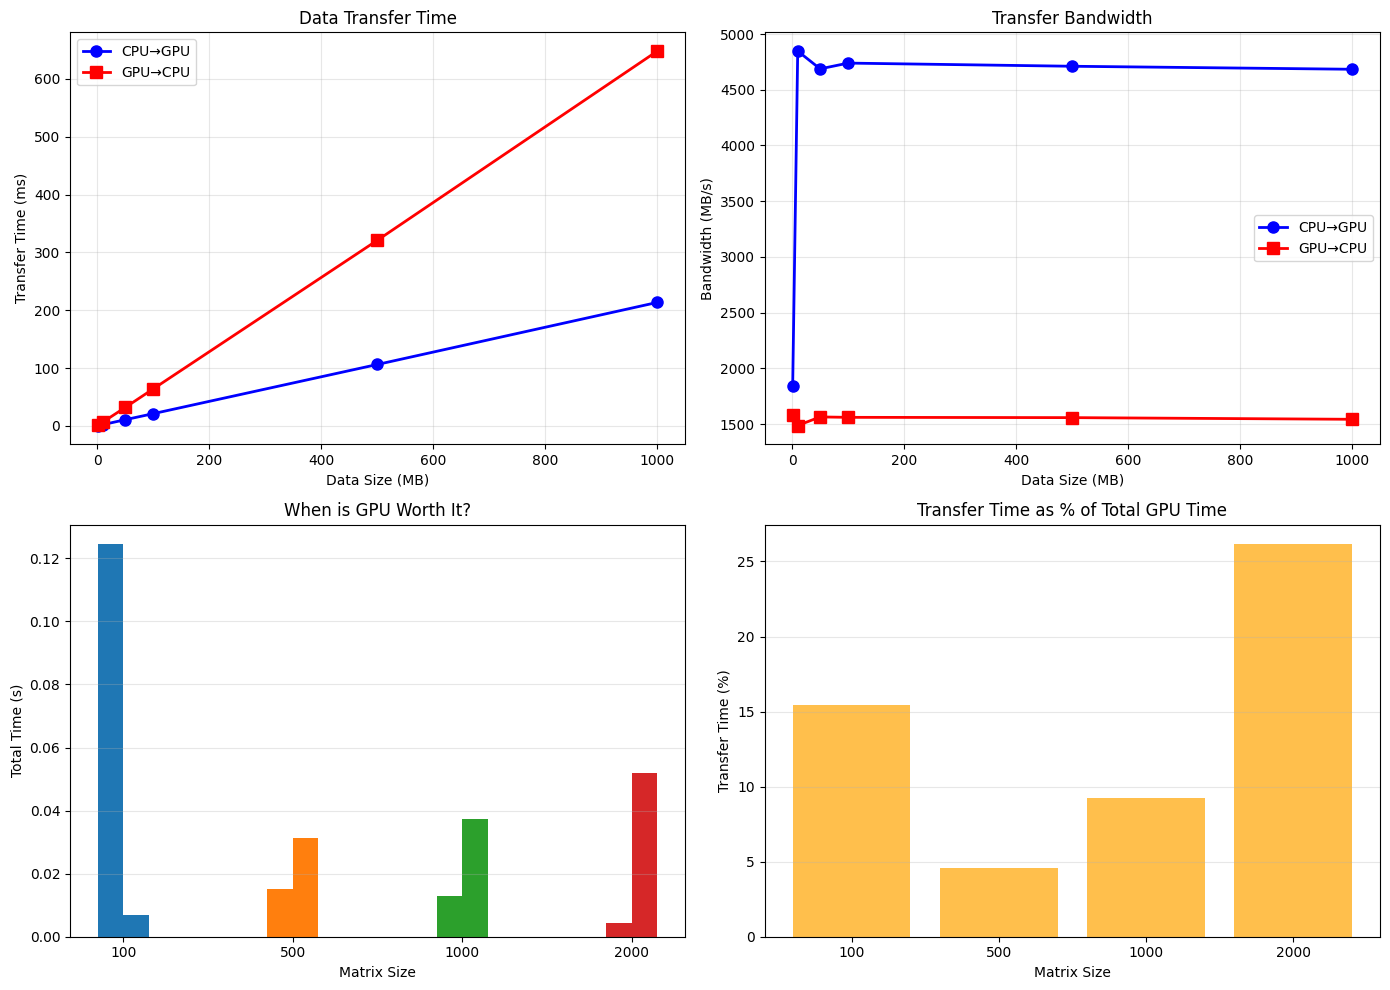

In [24]:
# Visualize transfer overhead
if transfer_results:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    sizes = [r['size_mb'] for r in transfer_results]
    cpu_to_gpu = [r['cpu_to_gpu_time']*1000 for r in transfer_results]
    gpu_to_cpu = [r['gpu_to_cpu_time']*1000 for r in transfer_results]
    bandwidth_to_gpu = [r['bandwidth_to_gpu'] for r in transfer_results]
    bandwidth_to_cpu = [r['bandwidth_to_cpu'] for r in transfer_results]

    # Transfer times
    ax1.plot(sizes, cpu_to_gpu, 'b-o', label='CPU→GPU', linewidth=2, markersize=8)
    ax1.plot(sizes, gpu_to_cpu, 'r-s', label='GPU→CPU', linewidth=2, markersize=8)
    ax1.set_xlabel('Data Size (MB)')
    ax1.set_ylabel('Transfer Time (ms)')
    ax1.set_title('Data Transfer Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Bandwidth
    ax2.plot(sizes, bandwidth_to_gpu, 'b-o', label='CPU→GPU', linewidth=2, markersize=8)
    ax2.plot(sizes, bandwidth_to_cpu, 'r-s', label='GPU→CPU', linewidth=2, markersize=8)
    ax2.set_xlabel('Data Size (MB)')
    ax2.set_ylabel('Bandwidth (MB/s)')
    ax2.set_title('Transfer Bandwidth')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Cost-benefit analysis
    ax3.set_title('When is GPU Worth It?')
    matrix_sizes_for_plot = [100, 500, 1000, 2000]
    for mat_size in matrix_sizes_for_plot:
        # Estimate transfer time for matrix of this size
        data_size_mb = mat_size * mat_size * 4 * 2 / 1e6  # Two matrices
        # Interpolate transfer time
        if data_size_mb <= max(sizes):
            transfer_time = np.interp(data_size_mb, sizes, cpu_to_gpu) / 1000  # Convert to seconds

            # Get computation times from earlier
            if mat_size in matrix_sizes and cpu_times and gpu_times:
                idx = matrix_sizes.index(mat_size)
                if idx < len(cpu_times) and idx < len(gpu_times):
                    cpu_compute = cpu_times[idx]
                    gpu_compute = gpu_times[idx]
                    gpu_total = gpu_compute + transfer_time * 2  # Transfer both ways

                    categories = ['CPU Only', 'GPU+Transfer']
                    times = [cpu_compute, gpu_total]
                    x_pos = matrix_sizes_for_plot.index(mat_size)
                    width = 0.15
                    ax3.bar([x_pos - width/2, x_pos + width/2], times, width,
                           label=f'Size {mat_size}' if mat_size == matrix_sizes_for_plot[0] else "")

    ax3.set_xlabel('Matrix Size')
    ax3.set_ylabel('Total Time (s)')
    ax3.set_xticks(range(len(matrix_sizes_for_plot)))
    ax3.set_xticklabels(matrix_sizes_for_plot)
    ax3.grid(True, alpha=0.3, axis='y')

    # Memory transfer vs computation ratio
    ax4.set_title('Transfer Time as % of Total GPU Time')
    transfer_percentages = []
    for mat_size in matrix_sizes_for_plot:
        data_size_mb = mat_size * mat_size * 4 * 2 / 1e6
        if data_size_mb <= max(sizes) and mat_size in matrix_sizes:
            transfer_time = np.interp(data_size_mb, sizes, cpu_to_gpu) / 1000
            idx = matrix_sizes.index(mat_size)
            if idx < len(gpu_times):
                gpu_compute = gpu_times[idx]
                transfer_percent = (transfer_time * 2) / (gpu_compute + transfer_time * 2) * 100
                transfer_percentages.append(transfer_percent)

    if transfer_percentages:
        ax4.bar(range(len(transfer_percentages)), transfer_percentages, color='orange', alpha=0.7)
        ax4.set_xlabel('Matrix Size')
        ax4.set_ylabel('Transfer Time (%)')
        ax4.set_xticks(range(len(transfer_percentages)))
        ax4.set_xticklabels(matrix_sizes_for_plot[:len(transfer_percentages)])
        ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

## Section 4: Training Performance Analysis

Now let's analyze how different hyperparameters affect training performance and memory usage.

### 4.1 Create a Simple Dataset and Model

In [25]:
# Create synthetic dataset
def create_synthetic_dataset(num_samples=10000, input_dim=100, num_classes=10):
    """Create a synthetic classification dataset."""
    X = torch.randn(num_samples, input_dim)
    y = torch.randint(0, num_classes, (num_samples,))
    return X, y

# TODO: Create train and validation datasets
X, y = create_synthetic_dataset()
n_train = 8000
X_train, y_train = X[:n_train], y[:n_train]  # Create with 8000 samples
X_val, y_val = X[n_train:], y[n_train:]  # Create with 2000 samples

print(f"Training set shape: {X_train.shape if X_train is not None else 'Not created'}")
print(f"Validation set shape: {X_val.shape if X_val is not None else 'Not created'}")

Training set shape: torch.Size([8000, 100])
Validation set shape: torch.Size([2000, 100])


In [26]:
# Define a configurable model
class ConfigurableNet(nn.Module):
    def __init__(self, input_dim=100, hidden_dims=[256, 128], num_classes=10):
        super().__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Test model creation
test_model = ConfigurableNet()
print(f"Model created with {sum(p.numel() for p in test_model.parameters())} parameters")

Model created with 60042 parameters


### 4.2 Training Function with Profiling

In [28]:
def train_with_profiling(config):
    """Train model with given configuration and profile performance."""
    # Extract config
    device = config['device']
    batch_size = config['batch_size']
    hidden_dims = config['hidden_dims']
    optimizer_type = config['optimizer']
    num_epochs = config.get('num_epochs', 5)

    # Clear memory before starting
    clear_gpu_memory()

    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = ConfigurableNet(hidden_dims=hidden_dims).to(device)
    criterion = nn.CrossEntropyLoss()

    # Create optimizer
    if optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_type}")

    # Training metrics
    metrics = {
        'train_time': 0,
        'val_time': 0,
        'peak_memory_gb': 0,
        'avg_batch_time': 0,
        'total_time': 0,
        'final_loss': 0
    }

    start_time = time.perf_counter()
    batch_times = []

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_start = time.perf_counter()

        for batch_idx, (data, target) in enumerate(train_loader):
            batch_start = time.perf_counter()

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            batch_times.append(time.perf_counter() - batch_start)

            if batch_idx == 0 and epoch == 0:
                # Record peak memory after first batch
                if device == 'cuda':
                    metrics['peak_memory_gb'] = torch.cuda.max_memory_allocated() / 1e9

        metrics['train_time'] += time.perf_counter() - train_start

        # Validation phase
        model.eval()
        val_start = time.perf_counter()
        val_loss = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()

        metrics['val_time'] += time.perf_counter() - val_start
        metrics['final_loss'] = val_loss / len(val_loader)

    metrics['total_time'] = time.perf_counter() - start_time
    metrics['avg_batch_time'] = np.mean(batch_times) * 1000  # Convert to ms

    # Clean up
    del model, optimizer
    clear_gpu_memory()

    return metrics

### 4.3 Compare Different Configurations

In [31]:
# TODO: Define different configurations to test
configurations = [
    # Configuration 1: Small model, small batch, CPU
    {
        'name': 'Small-CPU-BS32',
        'device': 'cpu',
        'batch_size': 32,
        'hidden_dims': [128, 64],
        'optimizer': 'sgd',
        'num_epochs': 3
    },

    {
        'name': 'Small-CPU-BS16',
        'device': 'cuda',
        'batch_size': 16,
        'hidden_dims': [128, 64],
        'optimizer': 'sgd',
        'num_epochs': 3
    },
     {
        'name': 'Small-CPU-BS32-adam',
        'device': 'cpu',
        'batch_size': 32,
        'hidden_dims': [128, 64],
        'optimizer': 'adam',
        'num_epochs': 3
    }
    # TODO: Add more configurations
    # Try different combinations of:
    # - device: 'cpu' vs 'cuda'
    # - batch_size: 16, 32, 64, 128, 256
    # - hidden_dims: [128, 64] vs [256, 128] vs [512, 256, 128]
    # - optimizer: 'sgd' vs 'adam'
]

# Add GPU configurations if available
if torch.cuda.is_available():
    configurations.extend([
        {
            'name': 'Small-GPU-BS32',
            'device': 'cuda',
            'batch_size': 32,
            'hidden_dims': [128, 64],
            'optimizer': 'sgd',
            'num_epochs': 3
        },
         {
            'name': 'Small-GPU-BS16',
            'device': 'cuda',
            'batch_size': 16,
            'hidden_dims': [128, 64],
            'optimizer': 'sgd',
            'num_epochs': 3
        },
         {
            'name': 'Small-GPU-BS32',
            'device': 'cuda',
            'batch_size': 32,
            'hidden_dims': [128, 64],
            'optimizer': 'adam',
            'num_epochs': 3
        }
        # TODO: Add more GPU configurations
    ])

print(f"Testing {len(configurations)} configurations...")

Testing 6 configurations...


In [32]:
# Run experiments
experiment_results = []

for config in configurations:
    print(f"\nTesting configuration: {config['name']}")
    print(f"  Device: {config['device']}")
    print(f"  Batch Size: {config['batch_size']}")
    print(f"  Hidden Dims: {config['hidden_dims']}")
    print(f"  Optimizer: {config['optimizer']}")

    try:
        # TODO: Run training with profiling
        metrics = train_with_profiling(config)

        # Store results
        result = {'config': config, 'metrics': metrics}
        experiment_results.append(result)

        print(f"  Results:")
        print(f"    Total Time: {metrics['total_time']:.2f}s")
        print(f"    Avg Batch Time: {metrics['avg_batch_time']:.2f}ms")
        if config['device'] == 'cuda':
            print(f"    Peak Memory: {metrics['peak_memory_gb']:.3f}GB")
        print(f"    Final Loss: {metrics['final_loss']:.4f}")

    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"  ✗ Out of memory with this configuration!")
        else:
            print(f"  ✗ Error: {e}")


Testing configuration: Small-CPU-BS32
  Device: cpu
  Batch Size: 32
  Hidden Dims: [128, 64]
  Optimizer: sgd
  Results:
    Total Time: 1.51s
    Avg Batch Time: 1.33ms
    Final Loss: 2.3047

Testing configuration: Small-CPU-BS16
  Device: cuda
  Batch Size: 16
  Hidden Dims: [128, 64]
  Optimizer: sgd
  Results:
    Total Time: 2.72s
    Avg Batch Time: 1.46ms
    Peak Memory: 1.022GB
    Final Loss: 2.3090

Testing configuration: Small-CPU-BS32-adam
  Device: cpu
  Batch Size: 32
  Hidden Dims: [128, 64]
  Optimizer: adam
  Results:
    Total Time: 1.46s
    Avg Batch Time: 1.49ms
    Final Loss: 2.3194

Testing configuration: Small-GPU-BS32
  Device: cuda
  Batch Size: 32
  Hidden Dims: [128, 64]
  Optimizer: sgd
  Results:
    Total Time: 1.28s
    Avg Batch Time: 1.27ms
    Peak Memory: 1.023GB
    Final Loss: 2.3094

Testing configuration: Small-GPU-BS16
  Device: cuda
  Batch Size: 16
  Hidden Dims: [128, 64]
  Optimizer: sgd
  Results:
    Total Time: 2.38s
    Avg Batch Ti

### 4.4 Visualize Training Performance Results

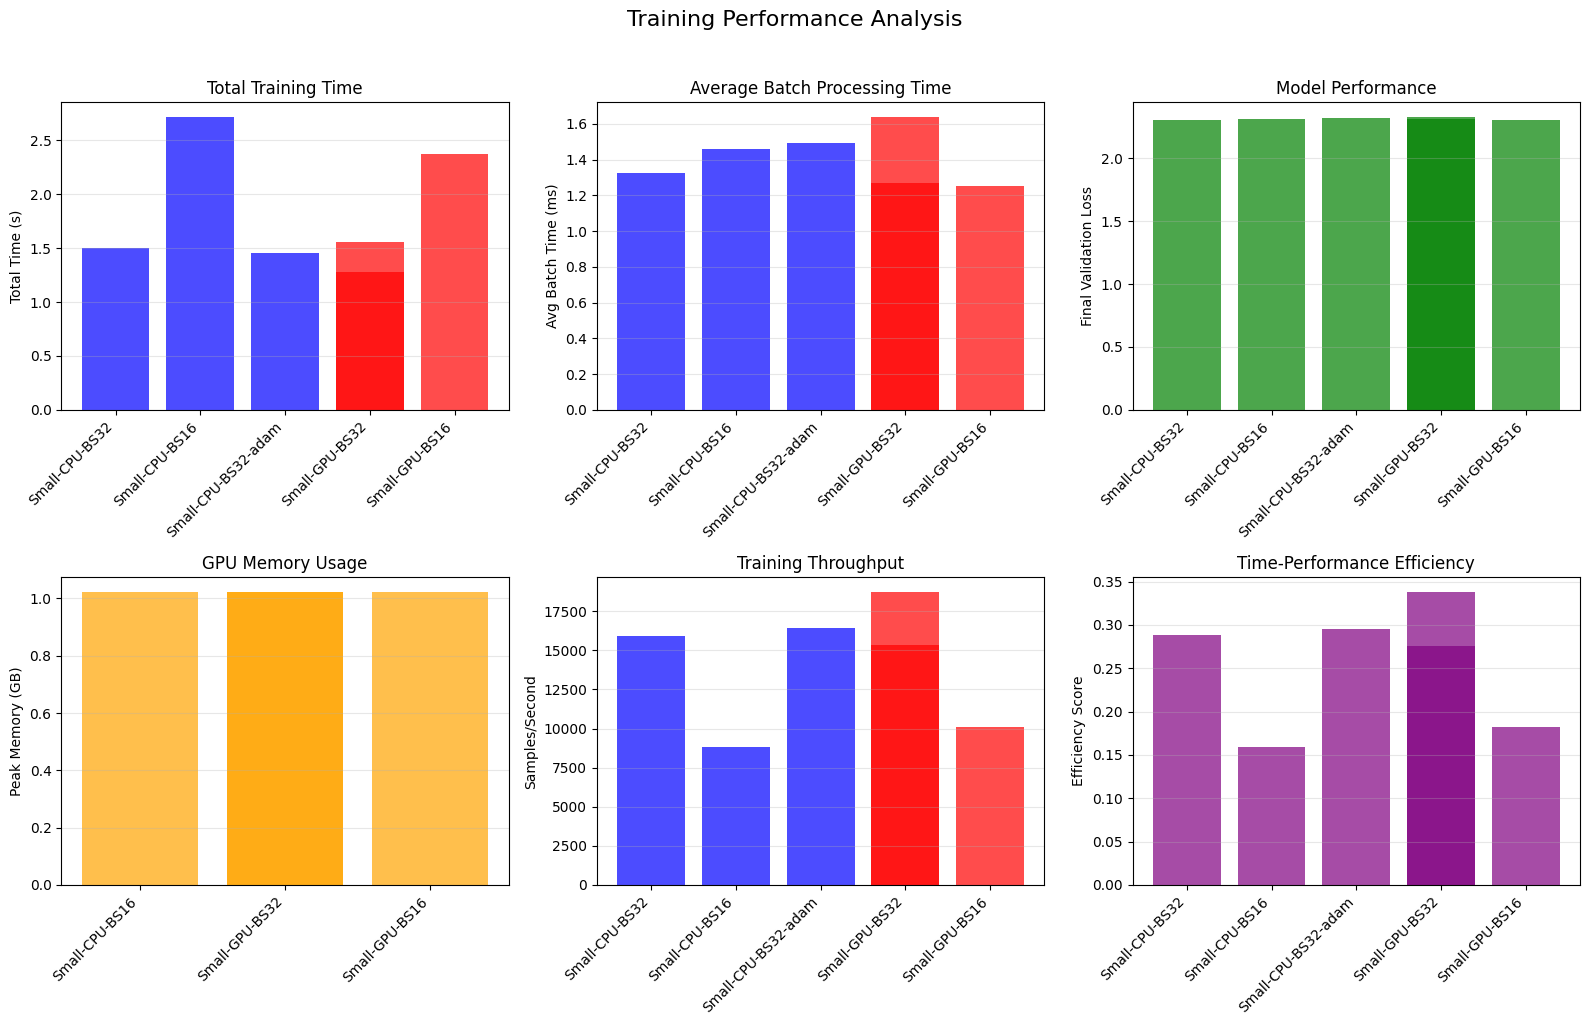

In [33]:
if experiment_results:
    # Prepare data for visualization
    names = [r['config']['name'] for r in experiment_results]
    total_times = [r['metrics']['total_time'] for r in experiment_results]
    batch_times = [r['metrics']['avg_batch_time'] for r in experiment_results]
    final_losses = [r['metrics']['final_loss'] for r in experiment_results]

    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 10))

    # Total training time
    ax1 = plt.subplot(2, 3, 1)
    bars1 = ax1.bar(names, total_times, color=['blue' if 'CPU' in n else 'red' for n in names], alpha=0.7)
    ax1.set_ylabel('Total Time (s)')
    ax1.set_title('Total Training Time')
    ax1.set_xticklabels(names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')

    # Batch processing time
    ax2 = plt.subplot(2, 3, 2)
    bars2 = ax2.bar(names, batch_times, color=['blue' if 'CPU' in n else 'red' for n in names], alpha=0.7)
    ax2.set_ylabel('Avg Batch Time (ms)')
    ax2.set_title('Average Batch Processing Time')
    ax2.set_xticklabels(names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')

    # Final loss
    ax3 = plt.subplot(2, 3, 3)
    bars3 = ax3.bar(names, final_losses, color='green', alpha=0.7)
    ax3.set_ylabel('Final Validation Loss')
    ax3.set_title('Model Performance')
    ax3.set_xticklabels(names, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')

    # GPU memory usage (if applicable)
    gpu_results = [r for r in experiment_results if r['config']['device'] == 'cuda']
    if gpu_results:
        ax4 = plt.subplot(2, 3, 4)
        gpu_names = [r['config']['name'] for r in gpu_results]
        memory_usage = [r['metrics']['peak_memory_gb'] for r in gpu_results]
        bars4 = ax4.bar(gpu_names, memory_usage, color='orange', alpha=0.7)
        ax4.set_ylabel('Peak Memory (GB)')
        ax4.set_title('GPU Memory Usage')
        ax4.set_xticklabels(gpu_names, rotation=45, ha='right')
        ax4.grid(True, alpha=0.3, axis='y')

    # Throughput (samples/second)
    ax5 = plt.subplot(2, 3, 5)
    throughputs = []
    for r in experiment_results:
        samples_per_epoch = len(X_train)
        epochs = r['config']['num_epochs']
        total_samples = samples_per_epoch * epochs
        throughput = total_samples / r['metrics']['total_time']
        throughputs.append(throughput)

    bars5 = ax5.bar(names, throughputs, color=['blue' if 'CPU' in n else 'red' for n in names], alpha=0.7)
    ax5.set_ylabel('Samples/Second')
    ax5.set_title('Training Throughput')
    ax5.set_xticklabels(names, rotation=45, ha='right')
    ax5.grid(True, alpha=0.3, axis='y')

    # Efficiency metric (inverse of time * loss)
    ax6 = plt.subplot(2, 3, 6)
    efficiencies = [1 / (t * l) for t, l in zip(total_times, final_losses)]
    bars6 = ax6.bar(names, efficiencies, color='purple', alpha=0.7)
    ax6.set_ylabel('Efficiency Score')
    ax6.set_title('Time-Performance Efficiency')
    ax6.set_xticklabels(names, rotation=45, ha='right')
    ax6.grid(True, alpha=0.3, axis='y')

    plt.suptitle('Training Performance Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

### 4.5 Summary and Best Practices

In [34]:
# Generate summary report
if experiment_results:
    print("\n" + "="*60)
    print("PERFORMANCE PROFILING SUMMARY")
    print("="*60)

    # Find best configurations
    fastest = min(experiment_results, key=lambda x: x['metrics']['total_time'])
    most_efficient = min(experiment_results, key=lambda x: x['metrics']['total_time'] * x['metrics']['final_loss'])

    print(f"\n🏃 Fastest Configuration: {fastest['config']['name']}")
    print(f"   Total Time: {fastest['metrics']['total_time']:.2f}s")
    print(f"   Device: {fastest['config']['device']}")

    print(f"\n⚡ Most Efficient Configuration: {most_efficient['config']['name']}")
    print(f"   Total Time: {most_efficient['metrics']['total_time']:.2f}s")
    print(f"   Final Loss: {most_efficient['metrics']['final_loss']:.4f}")

    # GPU vs CPU analysis
    cpu_results = [r for r in experiment_results if r['config']['device'] == 'cpu']
    gpu_results = [r for r in experiment_results if r['config']['device'] == 'cuda']

    if cpu_results and gpu_results:
        avg_cpu_time = np.mean([r['metrics']['total_time'] for r in cpu_results])
        avg_gpu_time = np.mean([r['metrics']['total_time'] for r in gpu_results])
        speedup = avg_cpu_time / avg_gpu_time

        print(f"\n🎯 GPU vs CPU Performance:")
        print(f"   Average CPU Time: {avg_cpu_time:.2f}s")
        print(f"   Average GPU Time: {avg_gpu_time:.2f}s")
        print(f"   GPU Speedup: {speedup:.2f}x")

    print("\n📚 Key Insights:")
    print("   1. GPU acceleration is most effective for large batch sizes and models")
    print("   2. Memory transfer overhead can negate GPU benefits for small operations")
    print("   3. Batch size significantly impacts both memory usage and training speed")
    print("   4. Adam optimizer typically uses more memory than SGD")
    print("   5. Monitor peak memory usage to avoid OOM errors in production")


PERFORMANCE PROFILING SUMMARY

🏃 Fastest Configuration: Small-GPU-BS32
   Total Time: 1.28s
   Device: cuda

⚡ Most Efficient Configuration: Small-GPU-BS32
   Total Time: 1.28s
   Final Loss: 2.3094

🎯 GPU vs CPU Performance:
   Average CPU Time: 1.48s
   Average GPU Time: 1.98s
   GPU Speedup: 0.75x

📚 Key Insights:
   1. GPU acceleration is most effective for large batch sizes and models
   2. Memory transfer overhead can negate GPU benefits for small operations
   3. Batch size significantly impacts both memory usage and training speed
   4. Adam optimizer typically uses more memory than SGD
   5. Monitor peak memory usage to avoid OOM errors in production
